In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import bloscpack as bp

import sys
import os
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from annotation_utilities import *
from registration_utilities import *
from vis3d_utilities import *
from metadata import *
from data_manager import *

import time

import matplotlib.pyplot as plt
%matplotlib inline

Setting environment for Precision WorkStation


No vtk


In [2]:
canonical_center_wrt_atlasSpace = load_data(DataManager.get_atlas_canonical_centroid_filepath(atlas_name='atlasV5'))

In [3]:
canonical_center_wrt_atlasSpace_um = canonical_center_wrt_atlasSpace * XY_PIXEL_DISTANCE_LOSSLESS * 32.

In [4]:
atlas_spec = dict(name='atlasV5', resolution='down32', vol_type='score')

In [5]:
SNR_R_vol_down32 = load_data('/home/yuncong/CSHL_meshes/atlasV5/mean_shapes/atlasV5_SNR_meanShape.bp')
SNR_R_ori_down32_wrt_canonicalAtlasSpace = load_data('/home/yuncong/CSHL_meshes/atlasV5/mean_shapes/atlasV5_SNR_meanShapeOrigin.txt')

In [6]:
SNR_L_nominal_location_down32_wrt_canonicalAtlasSpace = load_data('/home/yuncong/CSHL_meshes/atlasV5/atlasV5_meanPositions.pkl')['SNR_L']

In [9]:
SNR_L_vol_down32, SNR_L_origin_down32_wrt_canonicalAtlasSpace = \
mirror_volume_v2(SNR_R_vol_down32, SNR_L_nominal_location_down32_wrt_canonicalAtlasSpace - get_centroid_3d(SNR_R_vol_down32) * (1,1,-1))

In [12]:
SNR_L_mesh_level01_vertices, SNR_L_mesh_level01_faces = \
volume_to_polydata(volume=(SNR_L_vol_down32 >= .1, SNR_L_origin_down32_wrt_canonicalAtlasSpace), 
                     num_simplify_iter=3, smooth=True, 
                     return_vertex_face_list=True)

marching cube: 0.26 seconds
mesh_to_polydata: 0.07 seconds
simplify 0 @ 31806: 0.50 seconds
simplify 1 @ 6362: 0.59 seconds
simplify 2 @ 1274: 0.14 seconds


In [13]:
SNR_L_mesh_level01_um = mesh_to_polydata(vertices=SNR_L_mesh_level01_vertices * XY_PIXEL_DISTANCE_LOSSLESS * 32., 
                                         faces=SNR_L_mesh_level01_faces)

In [15]:
atlas_meshes_down32 = DataManager.load_meshes_v2(atlas_spec, 
                           sided=True, return_polydata_only=False, 
                           include_surround=False, levels=0.5)

In [16]:
atlas_meshes_um = {s: mesh_to_polydata(vertices=v* XY_PIXEL_DISTANCE_LOSSLESS * 32., faces=f) 
                   for s, (v, f) in atlas_meshes_down32.iteritems()}

In [17]:
atlas_meshes_um['SNR_L'] = SNR_L_mesh_level01_um

In [18]:
atlas_meshes_down32 = {s: rescale_polydata(m, factor=1./14.) for s, m in atlas_meshes_um.iteritems()}

In [19]:
atlas_structure_actors_down32 = {s: actor_mesh(m,  
                       color=np.array(name_unsided_to_color[convert_to_unsided_label(s)])/255.,
                                     opacity=(0.2 if s == 'SNR_L' else 0.1),
#                                     origin=canonical_center_wrt_atlasSpace_um
                                    )
            for s, m in atlas_meshes_down32.iteritems()}

In [20]:
atlas_structure_actors = {s: actor_mesh(m,  
                       color=np.array(name_unsided_to_color[convert_to_unsided_label(s)])/255.,
                                     opacity=(0.2 if s == 'SNR_L' else 0.1),
#                                     origin=canonical_center_wrt_atlasSpace_um
                                    )
            for s, m in atlas_meshes_um.iteritems()}

In [21]:
shell_polydata_down32_wrt_MD589wholebrain = DataManager.load_mesh_v2(brain_spec=dict(name='MD589', vol_type='annotationAsScore', resolution='10.0um'), structure='shell')
shell_polydata_um_wrt_MD589wholebrain = rescale_polydata(shell_polydata_down32_wrt_MD589wholebrain, 
                                convert_resolution_string_to_um(resolution='10.0um'))

# shell_actor_wrt_MD589wholebrain = actor_mesh(shell_polydata_um_wrt_MD589wholebrain, (1,1,1), opacity=.15, 
#                               wireframe=False, origin=- canonical_center_wrt_atlasSpace_um)

transform_matrix_from_MD589_to_canonicalAtlasSpace_um = \
np.array([[  9.99360483e-01,   1.60938754e-03,  -3.57253260e-02,  -1.17026747e+04],
 [  1.60938754e-03,   9.95949871e-01,   8.99051267e-02 , -6.06489183e+03],
 [  3.57253260e-02,  -8.99051267e-02,   9.95310353e-01 , -4.54015815e+03],
 [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00 ,  1.00000000e+00]])

shell_polydata_um_wrt_canonicalAtlasSpace = transform_polydata(transform=transform_matrix_from_MD589_to_canonicalAtlasSpace_um,
                  polydata=shell_polydata_um_wrt_MD589wholebrain)

shell_polydata_down32_wrt_canonicalAtlasSpace = rescale_polydata(shell_polydata_um_wrt_canonicalAtlasSpace, 1./14.)

shell_actor_um_wrt_canonicalAtlasSpace = actor_mesh(shell_polydata_um_wrt_canonicalAtlasSpace, (1,1,1), opacity=.15, 
                              wireframe=False)

shell_actor_down32_wrt_canonicalAtlasSpace = actor_mesh(shell_polydata_down32_wrt_canonicalAtlasSpace, (1,1,1), opacity=.15, 
                              wireframe=False)

In [22]:
launch_vtk(atlas_structure_actors.values() \
           + [shell_actor_um_wrt_canonicalAtlasSpace] \
           + [actor_sphere(position=(0,0,0), radius=5, color=(1,1,1), opacity=1.)])

In [32]:
experiments = {
#             'LM30': {'injection_structure': 'SNR_L', 'marker_color': (0,.5,0)},
#             'LM40': {'injection_structure': 'SNR_L', 'marker_color': (1,0,1)},
#             'LM30new': {'injection_structure': 'SNR_L', 'marker_color': (0,1,0)},
#             'LM40new': {'injection_structure': 'SNR_L', 'marker_color': (1,0,0)},
#             'LM31': {'injection_structure': 'SNR_L', 'marker_color': (0,0,1)},
#             'LM38': {'injection_structure': 'SNR_L', 'marker_color': (1,1,0)},
#             'LM48': {'injection_structure': 'SNR_L', 'marker_color': (0,1,1)},
#                 'LM42_LM37': {'injection_structure': 'SNR_L', 'marker_color': (1,0,1)},
#             'LM46': {'injection_structure': 'SNR_L', 'marker_color': np.array(random_colors(1)[0])/255.},
#             'LM22': {'injection_structure': 'SNR_L', 'marker_color': np.array(random_colors(1)[0])/255.},
#                 'LM41': {'injection_structure': 'SNR_L', 'marker_color': np.array(random_colors(1)[0])/255.},
#             'LM86': {'injection_structure': 'SNR_L', 'marker_color': np.array(random_colors(1)[0])/255.},
#             'LM84': {'injection_structure': 'SNR_L', 'marker_color': np.array(random_colors(1)[0])/255.},
#                 'LM32': {'injection_structure': 'SNR_L', 'marker_color': np.array(random_colors(1)[0])/255.},
#             'LM72': {'injection_structure': 'SNR_L', 'marker_color': np.array(random_colors(1)[0])/255.},
    
    'LM30new': {'injection_site': 'LSC', 'marker_color': (0,1,0)},
    'LM86': {'injection_site': 'LSC', 'marker_color': (0,1,0)},
    'LM27': {'injection_site': 'LSC', 'marker_color': (0,1,0)},
    
    'LM41': {'injection_site': 'CSC', 'marker_color': np.array([96, 201, 242])/255.},
    'LM22': {'injection_site': 'CSC', 'marker_color': np.array([96, 201, 242])/255.},
    'LM17': {'injection_site': 'CSC', 'marker_color': np.array([96, 201, 242])/255.},
    
    'LM37': {'injection_site': 'MSC', 'marker_color': np.array([255, 255, 0])/255.},
    
    'LM38': {'injection_site': 'IC', 'marker_color': np.array((180, 239, 86))/255.},
    'LM32': {'injection_site': 'IC', 'marker_color': np.array((180, 239, 86))/255.},
    
    'LM40new': {'injection_site': 'DR', 'marker_color': np.array((255, 0, 0))/255.},
    'LM54': {'injection_site': 'DR', 'marker_color': np.array((255, 0, 0))/255.},
    'LM94_LM96_LM25': {'injection_site': 'DR', 'marker_color': np.array((255, 0, 0))/255.},
    
    'LM46': {'injection_site': 'Pno', 'marker_color': np.array((0, 0, 255))/255.},
    'LM84': {'injection_site': 'Pno', 'marker_color': np.array((0, 0, 255))/255.},
    
    'LM31': {'injection_site': 'PcRT', 'marker_color': np.array((178, 0, 255))/255.},
    'LM48': {'injection_site': 'PcRT', 'marker_color': np.array((178, 0, 255))/255.},
    
#             'MD661': {'injection_structure': '5N_L', 'marker_color': (1,0,0)},
#              'MD662': {'injection_structure': '7N_L', 'marker_color': (0,1,0)},
#               'MD658': {'injection_structure': '5N_L', 'marker_color': (0,0,1)}
}

In [33]:
marker_resolution = '10.0um'

In [140]:
markers_rel2atlas_actors = {}
aligned_markers_rel2atlas_um_all_brains = {}

for brain_name, experiment_info in experiments.iteritems():
    
    # Load Neurolucida format.
    
    markers = load_data(DataManager.get_lauren_markers_filepath(brain_name, structure='All', resolution=marker_resolution))
    
    sample_n = min(len(markers), max(len(markers)/5, 10))
    print brain_name, 'showing', sample_n, '/', len(markers)
    markers = markers[np.random.choice(range(len(markers)), size=sample_n, replace=False)]
    
    brain_f_spec = dict(name=brain_name, vol_type='annotationAsScore', structure='SNR_L', resolution='10.0um')
    brain_m_spec = dict(name='atlasV5', resolution='10.0um', vol_type='score', structure='SNR_L')
    alignment_spec = dict(stack_m=brain_m_spec, stack_f=brain_f_spec, warp_setting=7)
    
    tf_atlas_to_subj = DataManager.load_alignment_results_v3(alignment_spec, what='parameters', out_form=(4,4))
    
    markers_rel2subj = {marker_id: marker_xyz for marker_id, marker_xyz in enumerate(markers)}
    
    aligned_markers_rel2atlas = {marker_ind: transform_points(pts=p, transform=np.linalg.inv(tf_atlas_to_subj)) 
                                for marker_ind, p in markers_rel2subj.iteritems()}
    
    aligned_markers_rel2atlas_um = {marker_ind: p * convert_resolution_string_to_um(marker_resolution) \
                                    - canonical_center_wrt_atlasSpace_um
                                    for marker_ind, p in aligned_markers_rel2atlas.iteritems()}
    
#     aligned_markers_rel2atlas_um = {marker_ind: p * convert_resolution_string_to_um(marker_resolution) 
#                                     for marker_ind, p in aligned_markers_rel2atlas.iteritems()}

    aligned_markers_rel2atlas_um_all_brains[brain_name] = aligned_markers_rel2atlas_um

    markers_rel2atlas_actors[brain_name] = [actor_sphere(position=(x,y,z), radius=20, 
                                                        color=experiment_info['marker_color'],
                                                        opacity=.8 )
                               for marker_id, (x,y,z) in aligned_markers_rel2atlas_um.iteritems()]

LM94_LM96_LM25 showing 53 / 267
LM38 showing 10 / 10
LM30new showing 110 / 553
LM27 showing 227 / 1138
LM37 showing 6 / 6
LM22 showing 42 / 210
LM32 showing 33 / 165
LM17 showing 33 / 166
LM48 showing 79 / 399
LM31 showing 14 / 73
LM41 showing 70 / 350
LM84 showing 12 / 63
LM40new showing 10 / 36
LM86 showing 180 / 902
LM54 showing 6 / 6
LM46 showing 50 / 253


In [ ]:
launch_vtk([m for b, marker_actors in markers_rel2atlas_actors.iteritems() for m in marker_actors ] \
          + atlas_structure_actors.values() \
           + [shell_actor_um_wrt_canonicalAtlasSpace], 
           init_angle='sagittal'
          )

# Generate coronal planes at specific levels

In [ ]:
SNR_L_nominal_location_um_wrt_canonicalAtlasSpace = SNR_L_nominal_location_down32_wrt_canonicalAtlasSpace * convert_resolution_string_to_um('down32', stack='MD589')
SNR_L_vol_down32_level01 = SNR_L_vol_down32 >= 0.1
SNR_L_vol_down32_level01_centroid_wrt_SNR_L_origin = get_centroid_3d(SNR_L_vol_down32_level01)
print SNR_L_vol_down32_level01_centroid_wrt_SNR_L_origin
ydim, xdim, zdim = SNR_L_vol_down32_level01.shape

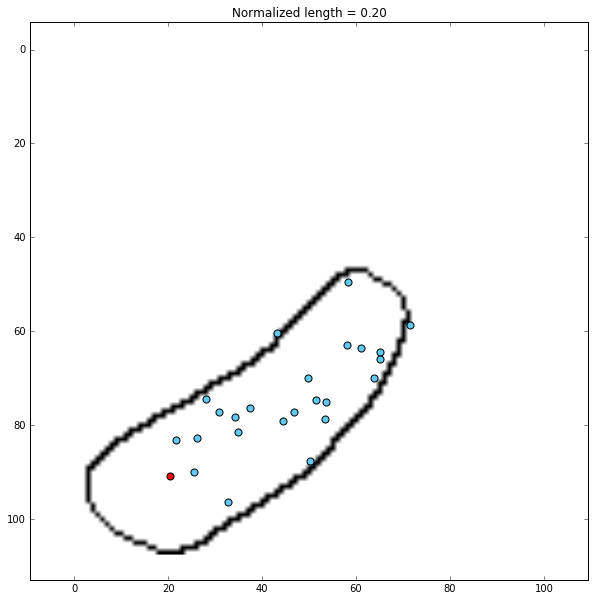

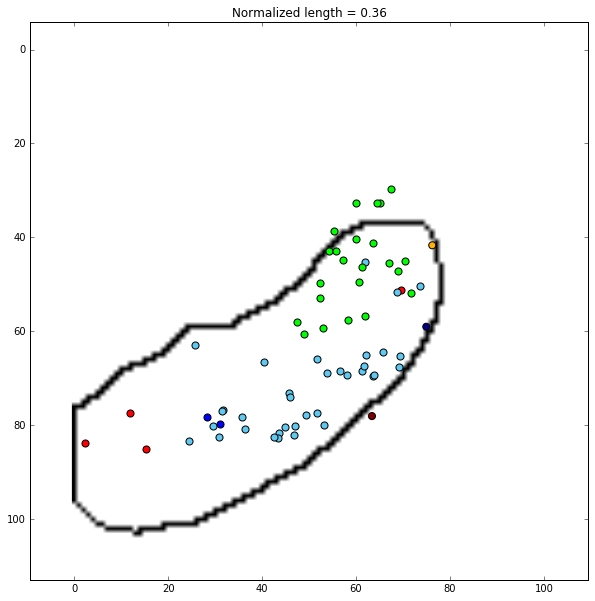

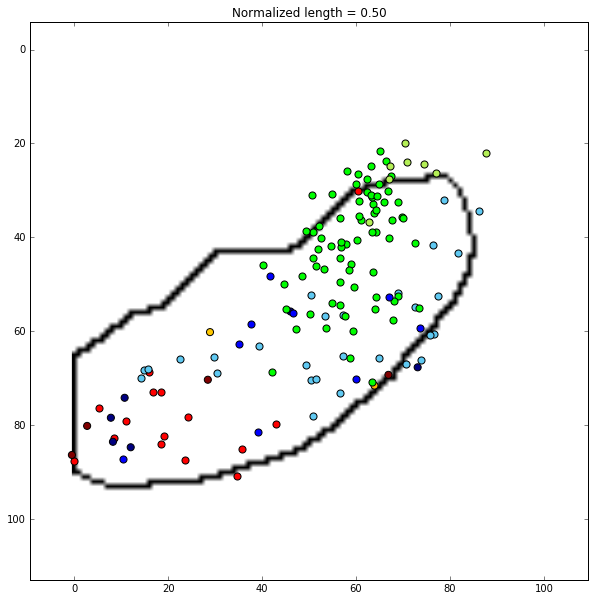

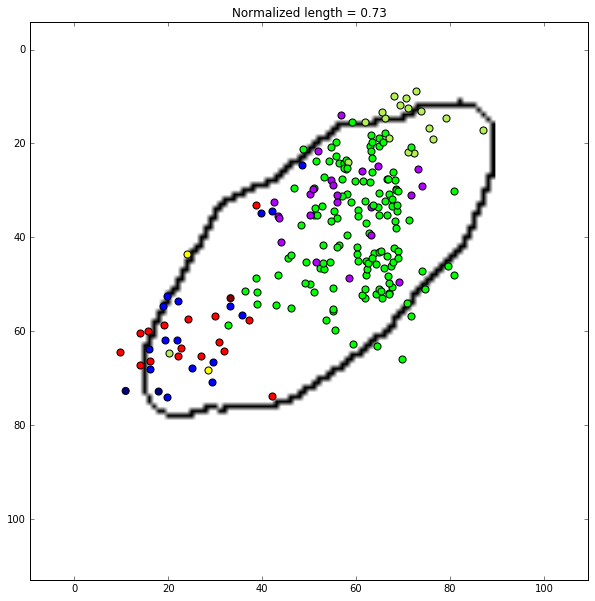

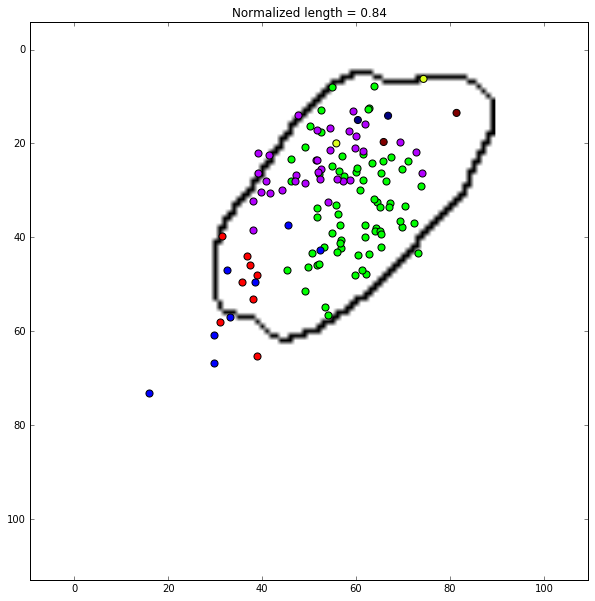

In [197]:
for r in [0.2, .36, 0.5, 0.73, 0.84]:
    
    plt.figure(figsize=(10,10));
    plt.axis('equal');
    plt.xlim([-50, 150]);
    
#     contour = find_contour_points(SNR_L_vol_down32_level01[:, int(xdim*r), :], sample_every=1)[1][0]
#     plt.scatter( contour[:,1], contour[:,0], c=(0,0,0));

    contour = np.maximum(0, find_contour_points(SNR_L_vol_down32_level01[:, int(xdim*r), :], sample_every=1)[1][0])
    viz = np.ones((ydim, zdim), np.uint8)
    viz[contour[:,1], zdim - 1 - contour[:,0]] = 0

#     plt.imshow(SNR_L_vol_down32_level01[:, int(xdim*r), ::-1], cmap=plt.cm.gray);

    plt.imshow(viz, cmap=plt.cm.gray);

    for brain_name, aligned_markers_rel2atlas_um in aligned_markers_rel2atlas_um_all_brains.iteritems():

        aligned_markers_rel2SNR_L_centroid_um = aligned_markers_rel2atlas_um.values() - SNR_L_nominal_location_um_wrt_canonicalAtlasSpace
        aligned_markers_rel2SNR_L_origin_um = aligned_markers_rel2SNR_L_centroid_um + SNR_L_vol_down32_level01_centroid_wrt_SNR_L_origin * convert_resolution_string_to_um('down32', 'MD589')
        aligned_markers_rel2SNR_L_origin_down32 = aligned_markers_rel2SNR_L_origin_um / convert_resolution_string_to_um('down32', 'MD589')

        on_plane = (aligned_markers_rel2SNR_L_origin_down32[:,0] < xdim*r + 5) & \
        (aligned_markers_rel2SNR_L_origin_down32[:,0] > xdim*r - 5)

        yzs = aligned_markers_rel2SNR_L_origin_down32[on_plane][:, [1,2]]

        plt.scatter(zdim - yzs[:,1],  yzs[:,0], c=experiments[brain_name]['marker_color'], s=50);
        
    plt.title('Normalized length = %.2f' % r);
    
    plt.savefig('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/ProjectionLabeling/lauren_data_v2/coronal_normalizedLevel_%.2f.png' % r)
    plt.show();
    
    

# Export all visualizations

In [ ]:
for stack in ['LM30new']:
# for stack in experiments.keys():
    
#     for view in ['coronal', 'horizontal_topDown', 'sagittal', '45']:
    for view in ['sagittal']:

        snapshot_fp = '/home/yuncong/Dropbox/BrainProjectFiguresByTopic/ProjectionLabeling/lauren_data_v2/%(view)s/%(stack)s_%(view)s.png' % {'stack':stack, 'view':view}
        create_parent_dir_if_not_exists(snapshot_fp)

        launch_vtk(
            atlas_structure_actors_down32.values() + \
#             markers_rel2atlas_actors[stack] + \
            [shell_actor_down32_wrt_canonicalAtlasSpace],
            background_color=(1,1,1), 
            axes_label_color=(0,0,0), 
            init_angle=view,
#                         interactive=False,
#                 snapshot_fn=snapshot_fp,
#             snapshot_magnification=2,
            view_up=(-0.012255, -0.999613, 0.024961),
            focal=(-165.374790, -21.539714, 3.094653),
            position= (-187.619574, -80.180217, -2356.163135),
        )
    